In [1]:
import os
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
#%matplotlib notebook
%matplotlib inline
#matplotlib.use('nbagg')
#import mpld3
#mpld3.enable_notebook()

from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.io
mat = scipy.io.loadmat("./ref/01.mat")
data = mat["data"]
wl = mat["wl"]
refconc= mat["refconc"]

In [3]:
print(data)
print(data.shape)
print(type(data))

#data1 = np.empty_like(data)
#print(data1.shape)

[[2753 2661 2683 ... 2638 2960 2844]
 [2679 2611 2599 ... 2553 2862 2768]
 [2737 2614 2610 ... 2629 2968 2802]
 ...
 [4533 3626 3758 ... 4494 5508 5224]
 [4572 3662 3746 ... 4468 5393 5235]
 [4599 3633 3763 ... 4624 5507 5238]]
(2046, 100)
<class 'numpy.ndarray'>


In [4]:
print(wl)
print(wl.shape)
print(type(wl))

[[173.7386]
 [173.8688]
 [173.999 ]
 ...
 [429.491 ]
 [429.6013]
 [429.7116]]
(2046, 1)
<class 'numpy.ndarray'>


In [5]:
print(data[:,-1].shape)
print(data[-1].shape)

(2046,)
(100,)


In [6]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

There are two parameters: p for asymmetry and λ for smoothness. Both have to be tuned to the data at hand. We found that generally 0.001 ≤ p ≤ 0.1 is a good choice (for a signal with positive peaks) and 10^2 ≤ λ ≤ 10^9, but exceptions may occur. In any case one should vary λ on a grid that is approximately linear for log λ. Often visual inspection is sufficient to get good parameter values.

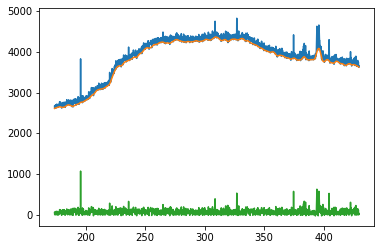

In [7]:
p=0.01
lam= 100

z = baseline_als(data[:,1], lam, p, niter=10)

plt.plot(wl, data[:,1])
plt.plot(wl, z)
plt.plot(wl,data[:,1]-z)

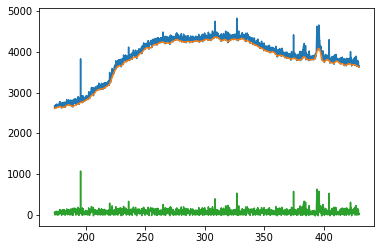

In [8]:
p=0.01
lam= 105

z = baseline_als(data[:,1], lam, p, niter=10)

plt.plot(wl, data[:,1])
plt.plot(wl, z)
plt.plot(wl,data[:,1]-z)

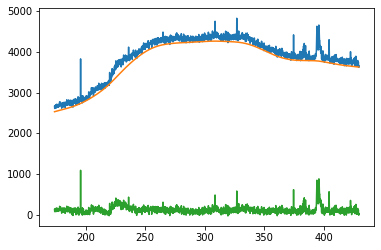

In [9]:
p=0.001
lam= 100000

z = baseline_als(data[:,1], lam, p, niter=10)

plt.plot(wl, data[:,1])
plt.plot(wl, z)
plt.plot(wl,data[:,1]-z)

In [10]:
print(len(wl))
wl[1730]

2046


array([393.7988])

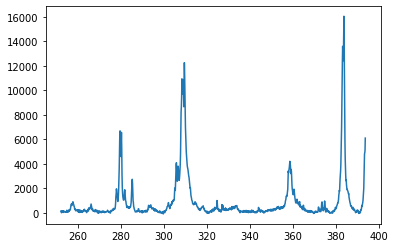

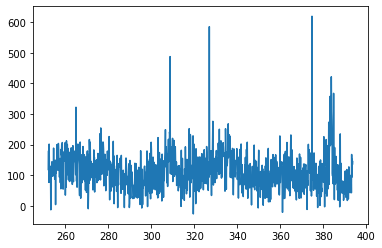

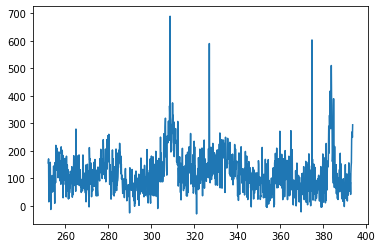

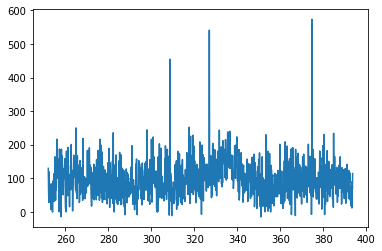

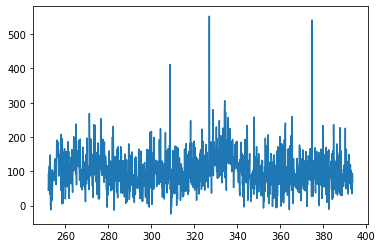

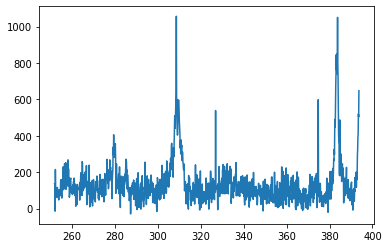

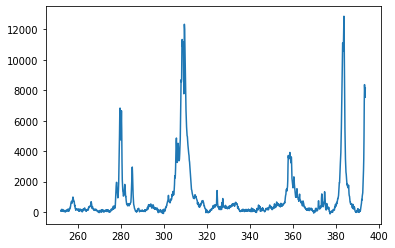

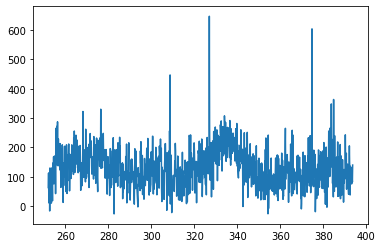

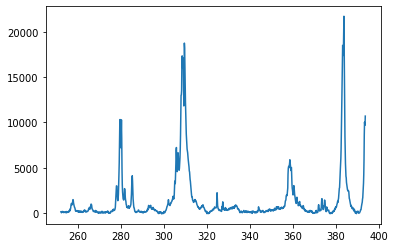

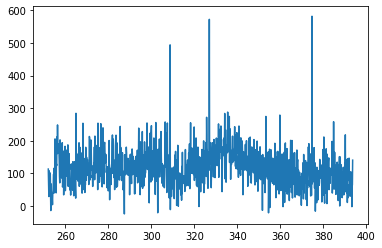

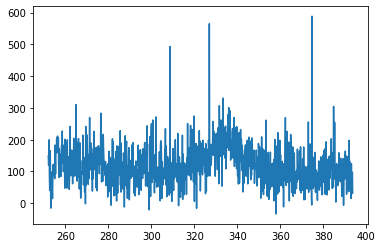

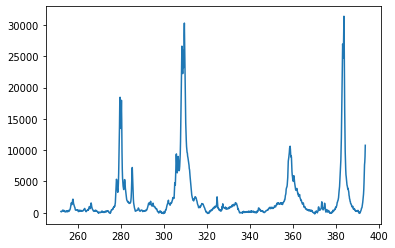

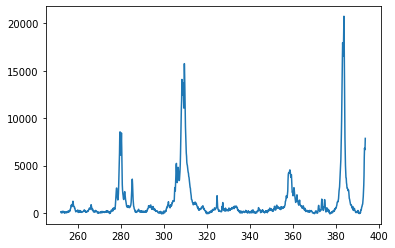

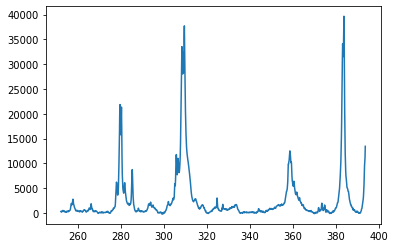

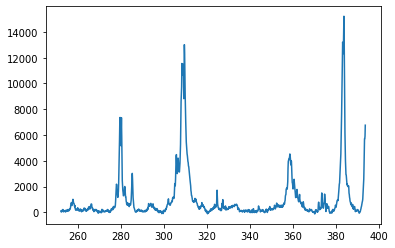

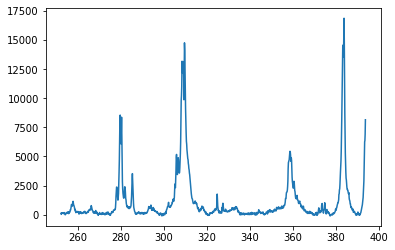

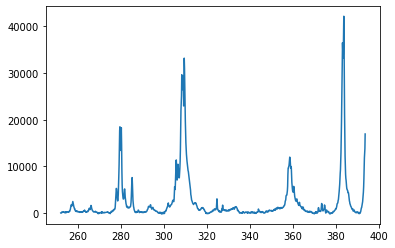

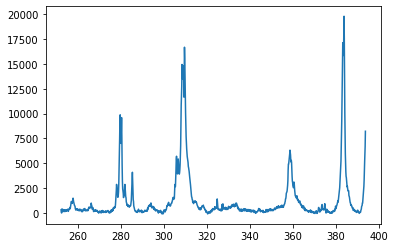

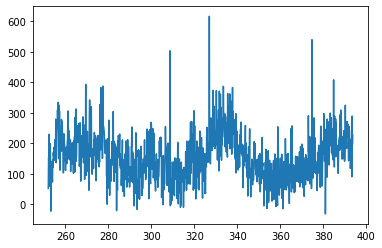

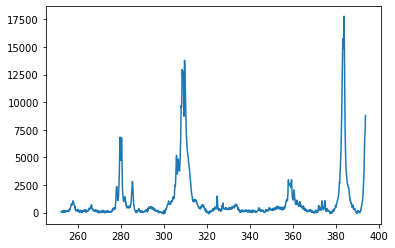

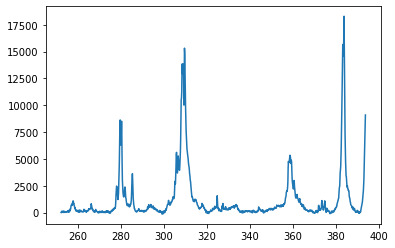

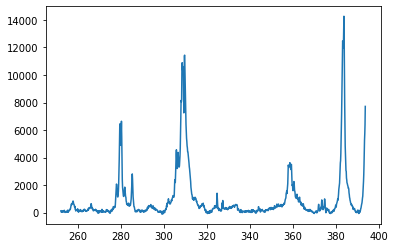

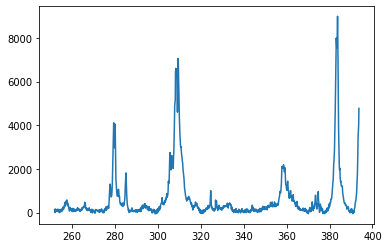

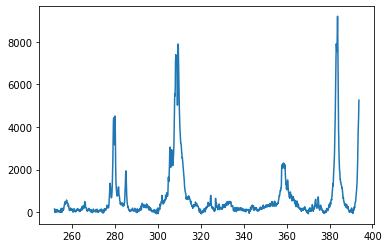

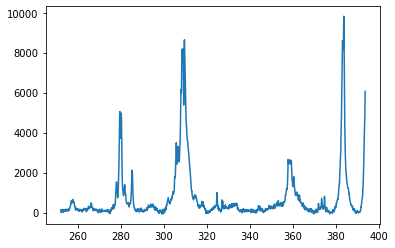

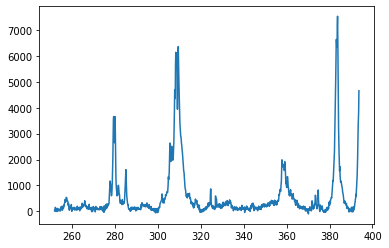

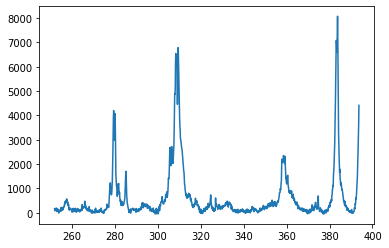

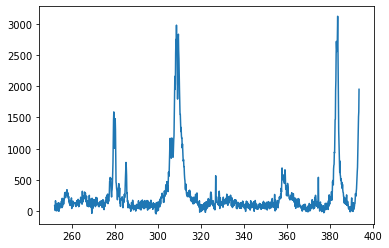

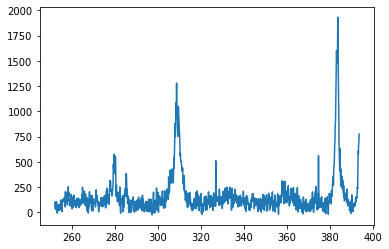

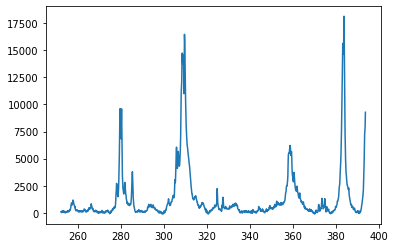

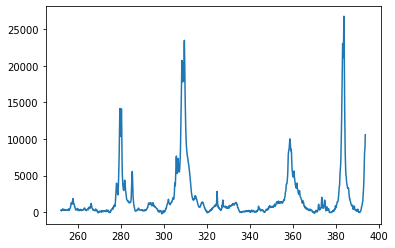

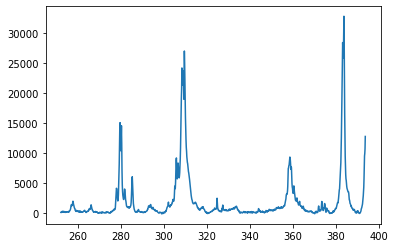

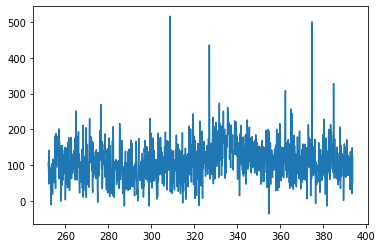

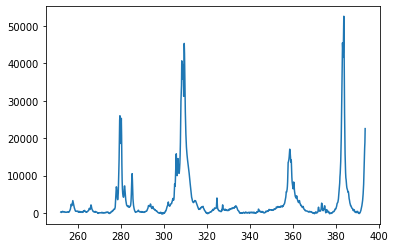

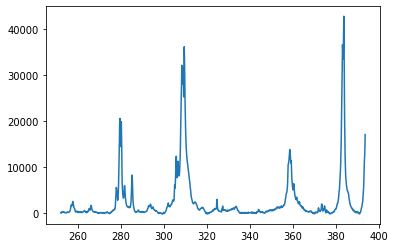

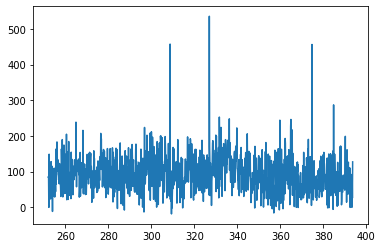

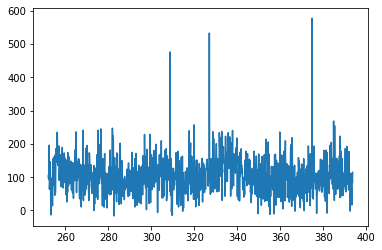

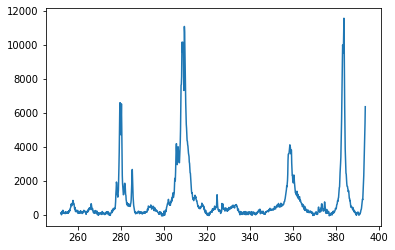

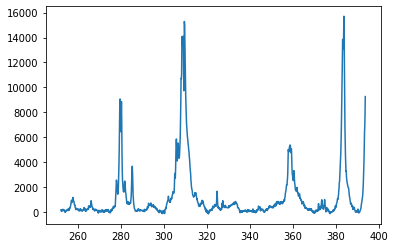

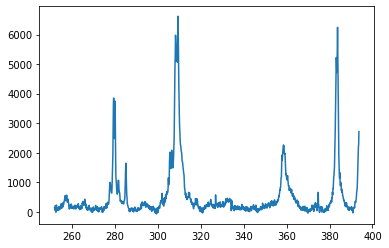

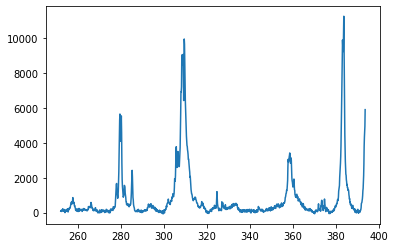

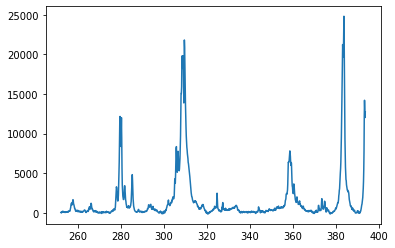

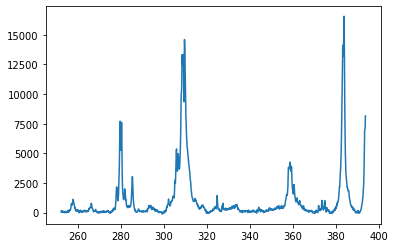

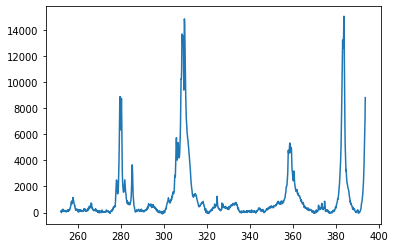

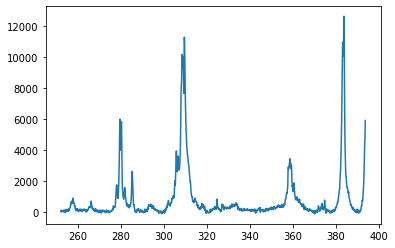

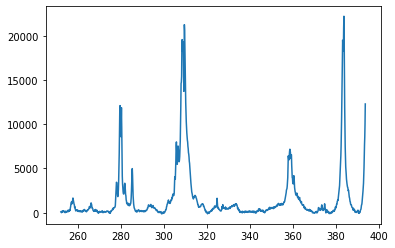

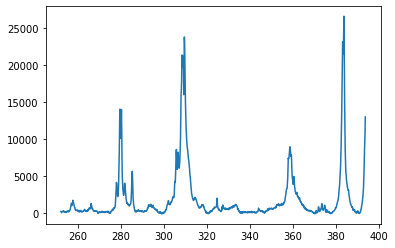

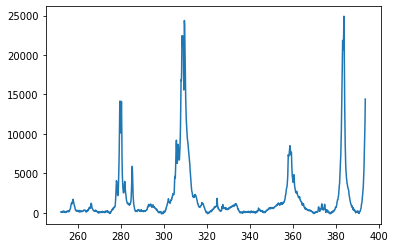

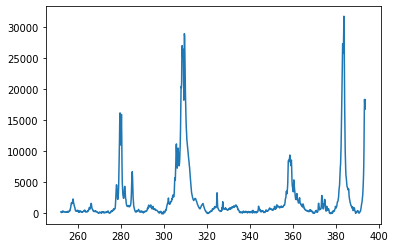

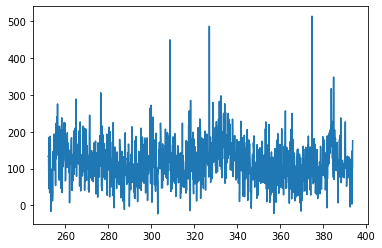

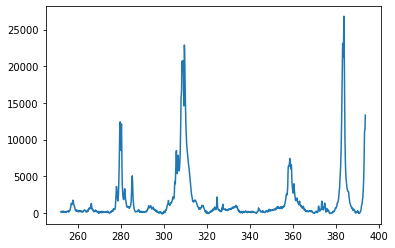

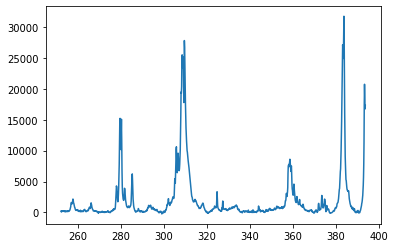

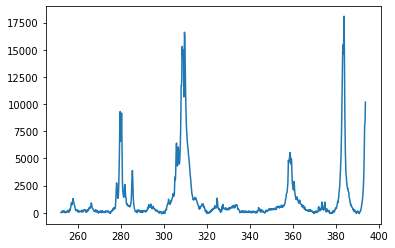

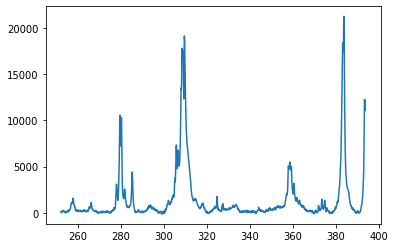

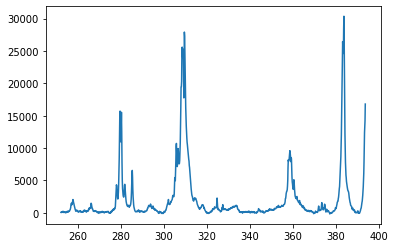

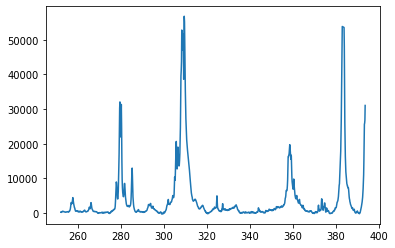

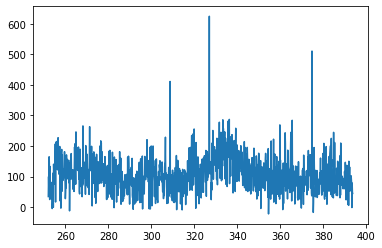

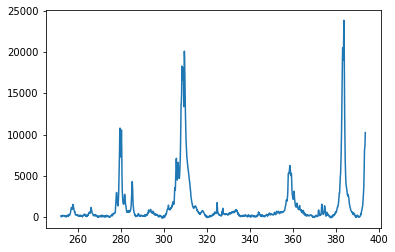

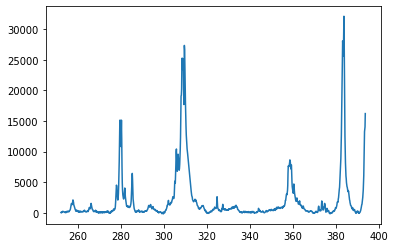

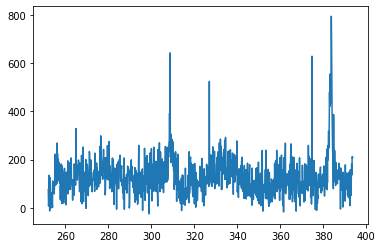

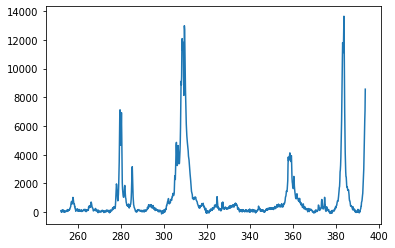

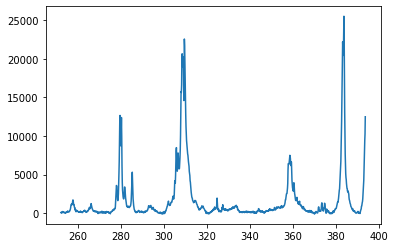

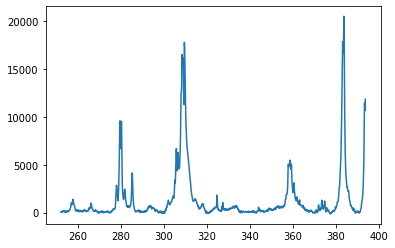

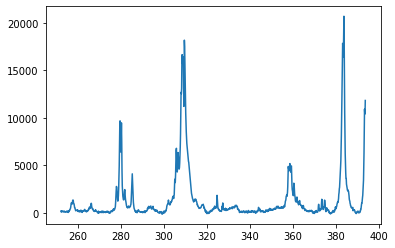

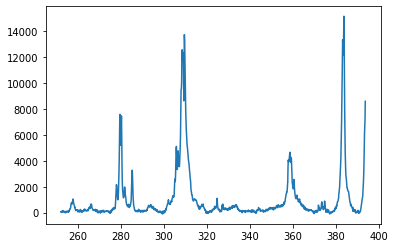

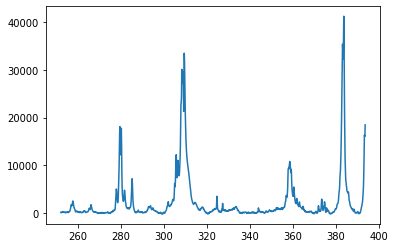

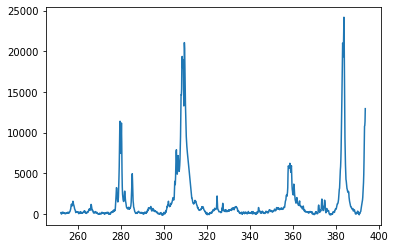

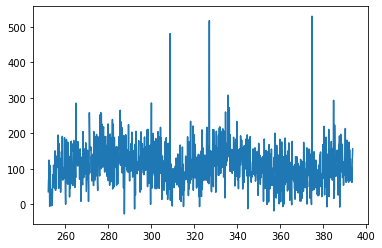

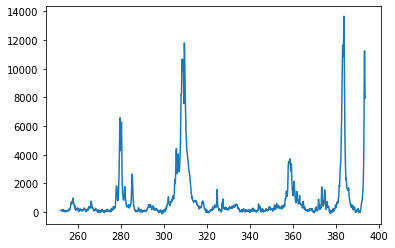

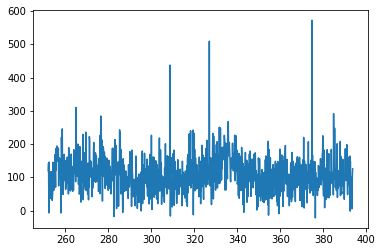

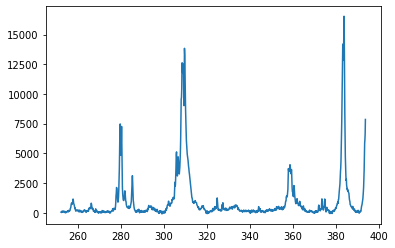

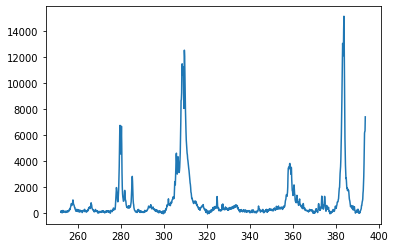

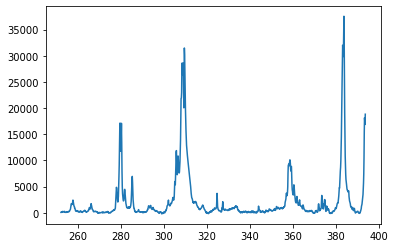

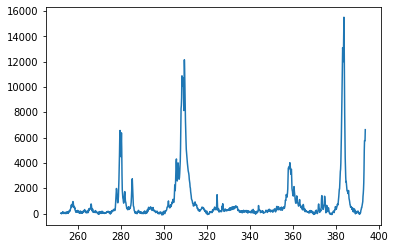

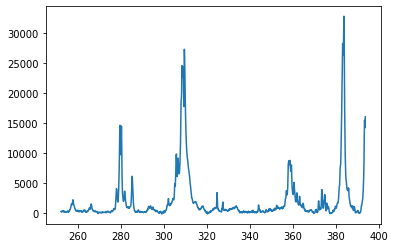

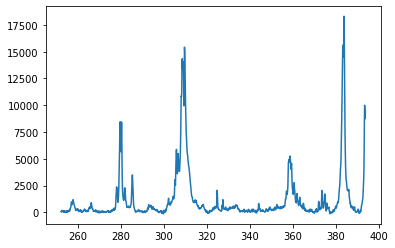

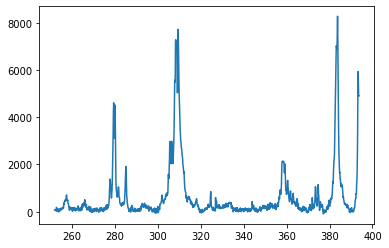

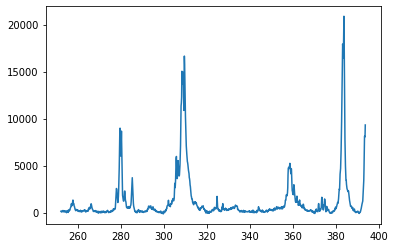

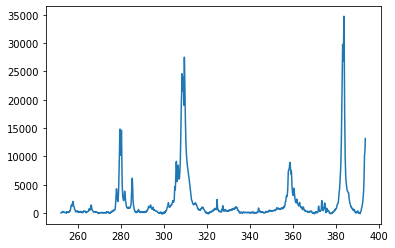

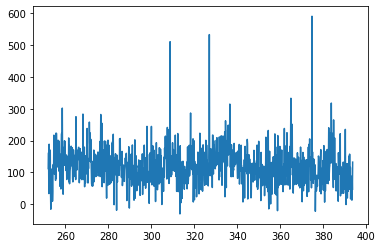

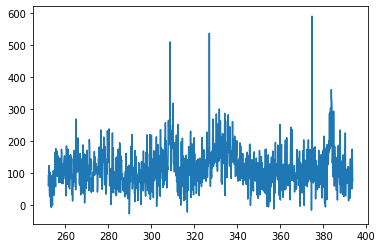

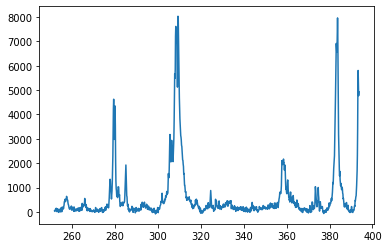

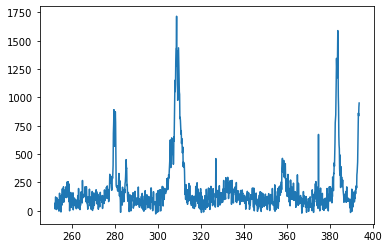

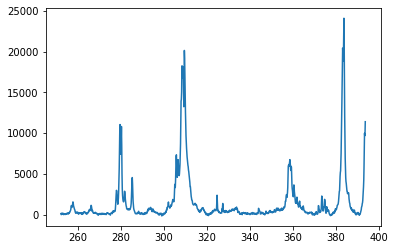

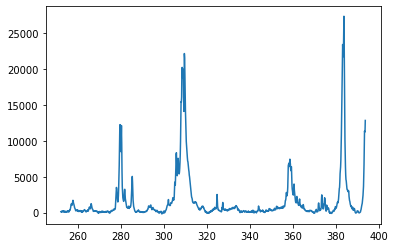

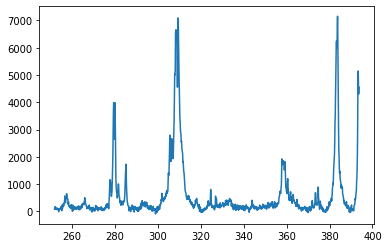

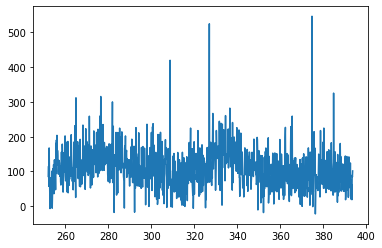

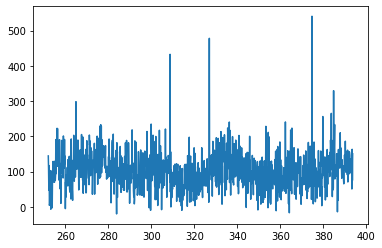

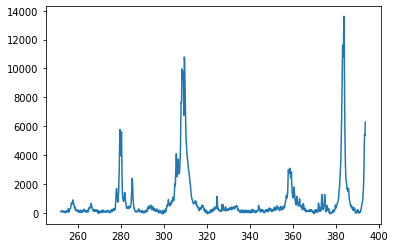

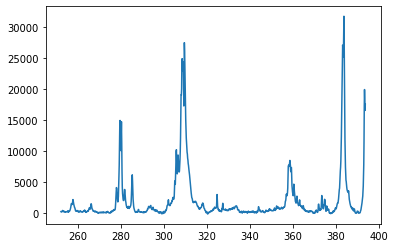

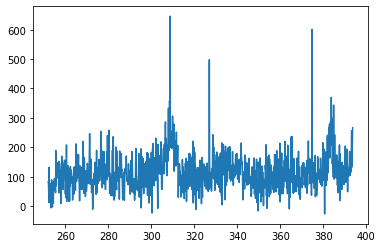

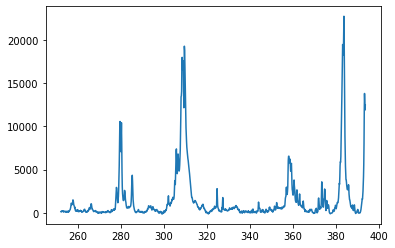

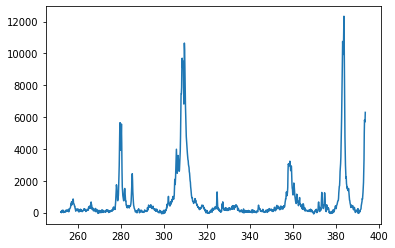

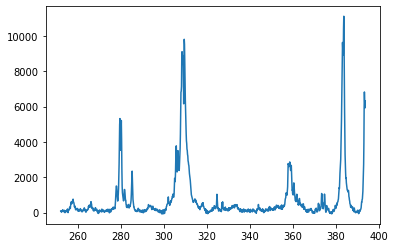

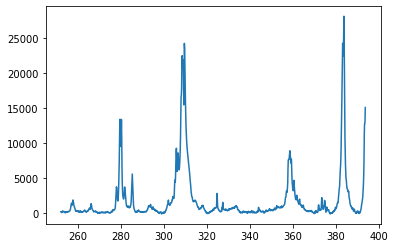

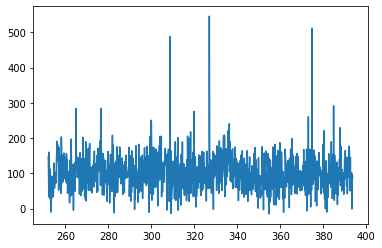

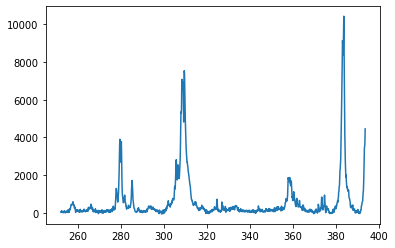

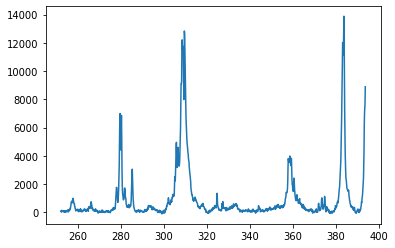

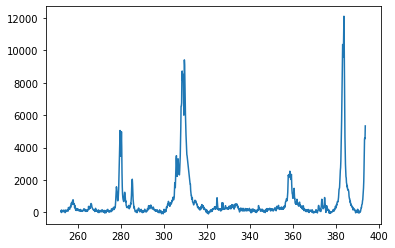

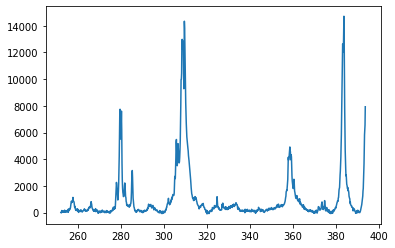

In [11]:
for i in (range(len(data[0]))):
    
    z_i = baseline_als(data[600:1730,i], lam, p, niter=10)
    
    plt.plot(wl[600:1730], data[600:1730,i] - z_i)
    plt.show()
    

In [12]:
X_std = StandardScaler().fit_transform(data)
print(X_std.shape)
X_std

(2046, 100)


array([[-0.68948268, -2.36764515, -2.34007443, ..., -0.56564966,
        -1.01539892, -0.73882164],
       [-0.70650736, -2.46508475, -2.49277351, ..., -0.5815389 ,
        -1.04291278, -0.75393671],
       [-0.69316369, -2.45923837, -2.4727772 , ..., -0.56733205,
        -1.01315289, -0.74717471],
       ...,
       [-0.27997017, -0.48706085, -0.38588982, ..., -0.21870359,
        -0.30003835, -0.2654813 ],
       [-0.27099771, -0.41690433, -0.40770398, ..., -0.22356382,
        -0.33232503, -0.2632936 ],
       [-0.264786  , -0.4734193 , -0.37680059, ..., -0.19440241,
        -0.30031911, -0.26269695]])

In [13]:
data_sum= data / np.sum(data,axis=0)
data_sum

array([[0.00023401, 0.00033555, 0.00033029, ..., 0.00022764, 0.00021998,
        0.00021193],
       [0.00022772, 0.00032925, 0.00031995, ..., 0.00022031, 0.00021269,
        0.00020627],
       [0.00023265, 0.00032963, 0.0003213 , ..., 0.00022686, 0.00022057,
        0.0002088 ],
       ...,
       [0.00038532, 0.00045724, 0.00046263, ..., 0.0003878 , 0.00040934,
        0.00038929],
       [0.00038863, 0.00046178, 0.00046115, ..., 0.00038556, 0.00040079,
        0.00039011],
       [0.00039093, 0.00045812, 0.00046324, ..., 0.00039902, 0.00040926,
        0.00039033]])

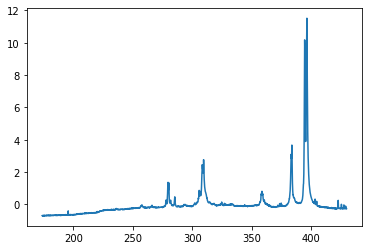

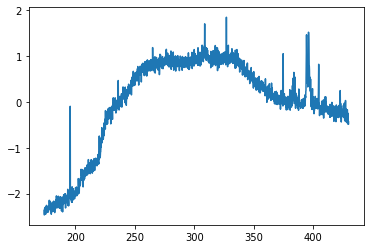

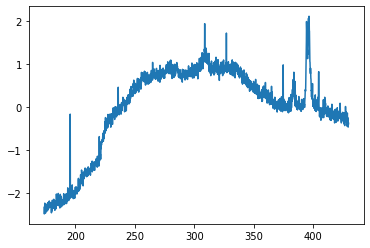

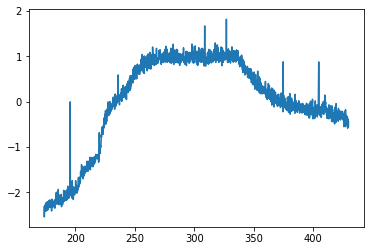

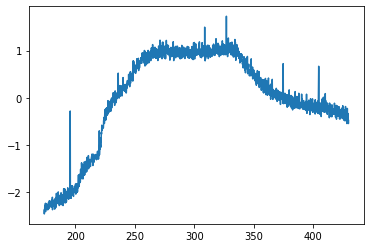

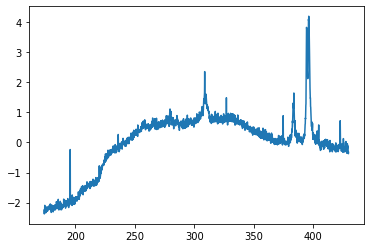

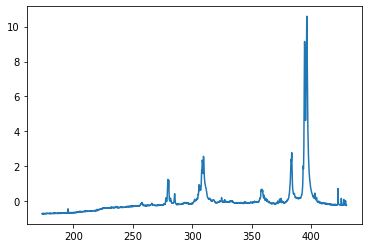

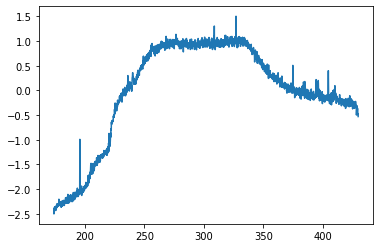

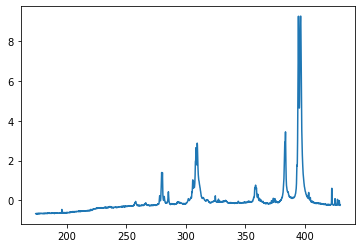

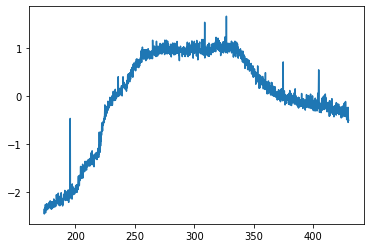

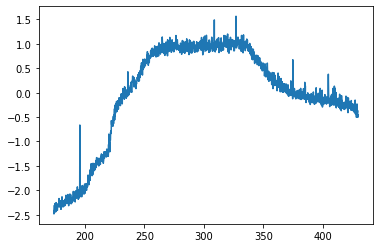

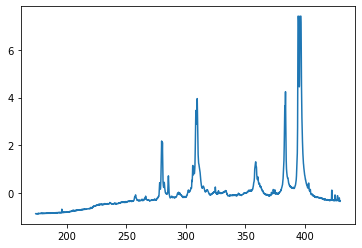

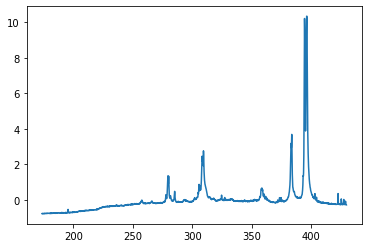

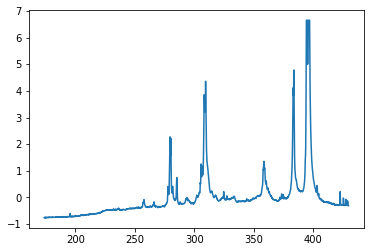

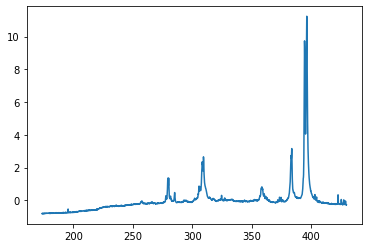

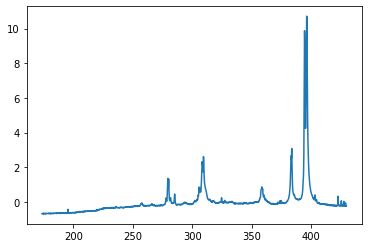

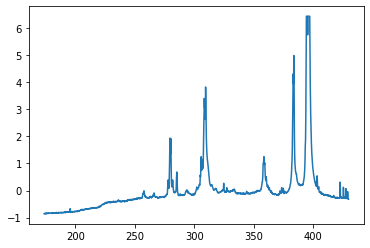

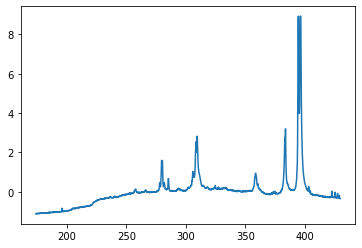

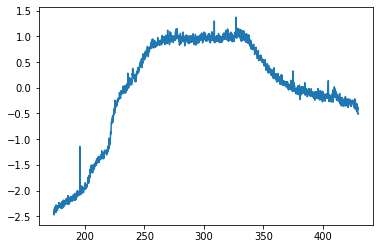

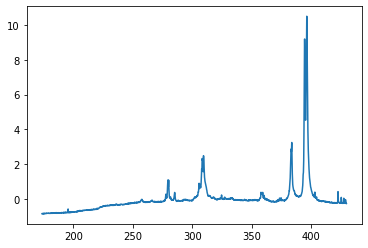

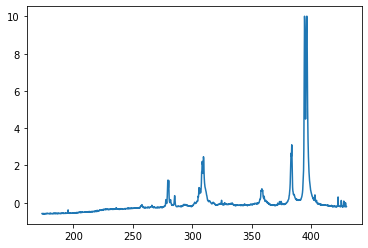

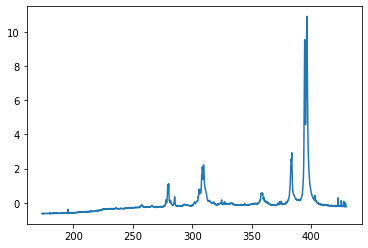

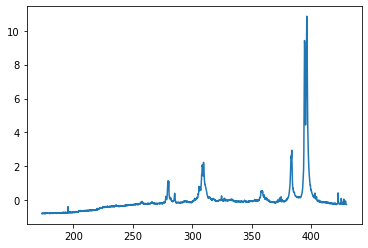

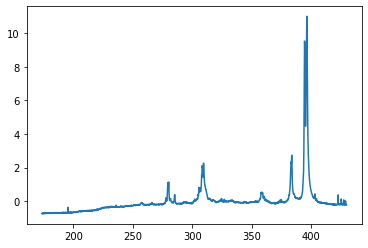

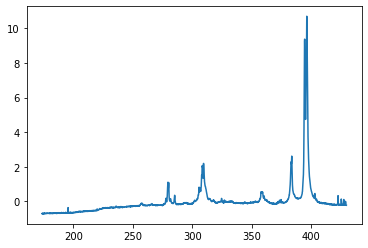

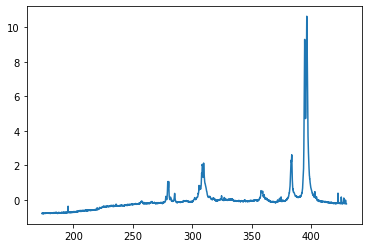

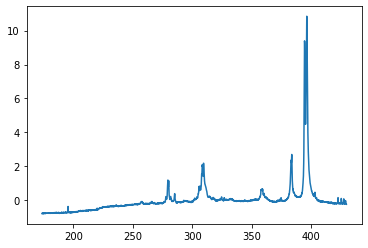

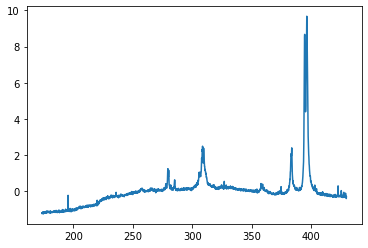

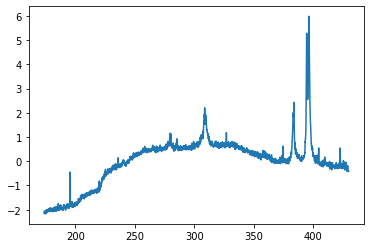

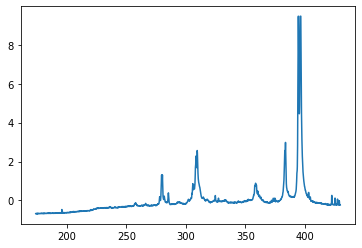

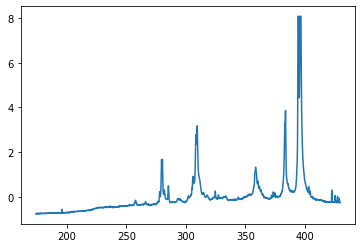

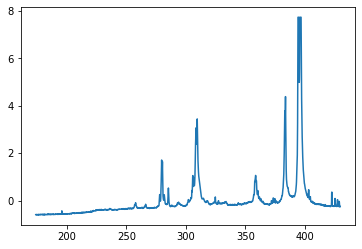

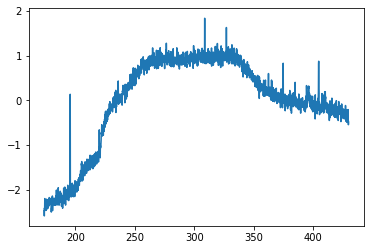

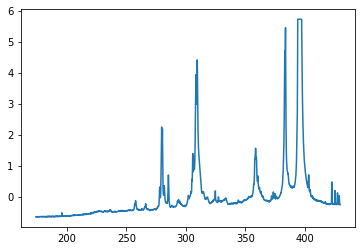

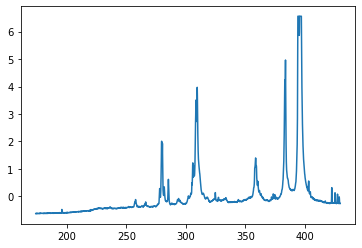

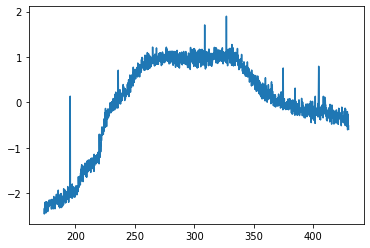

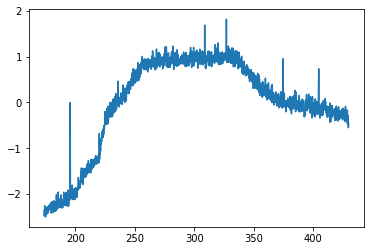

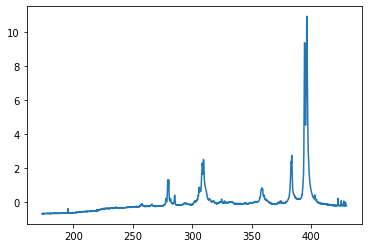

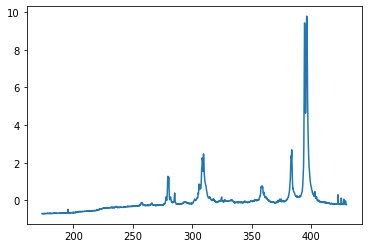

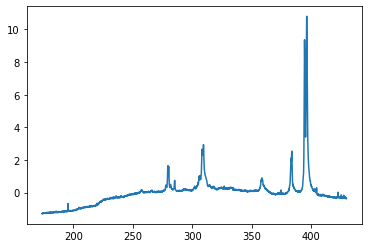

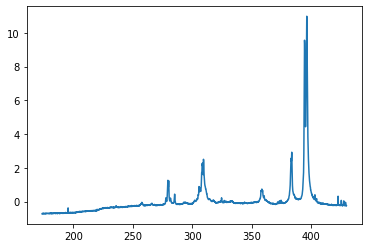

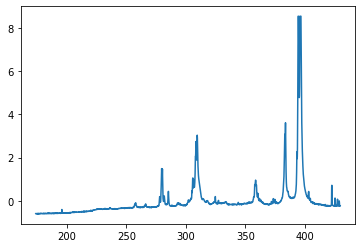

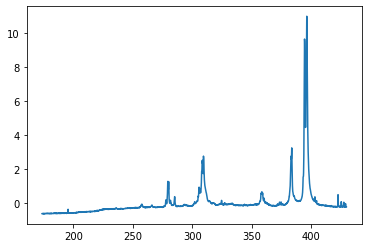

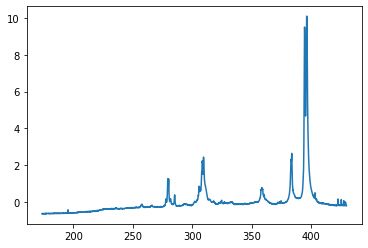

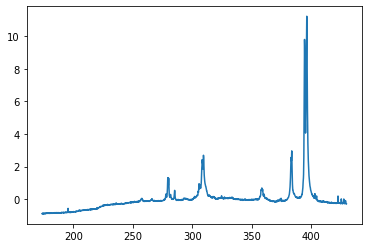

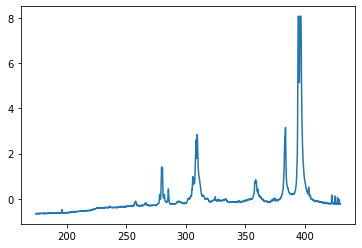

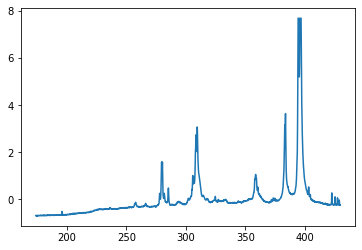

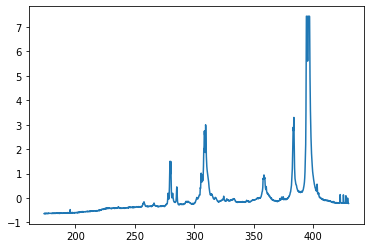

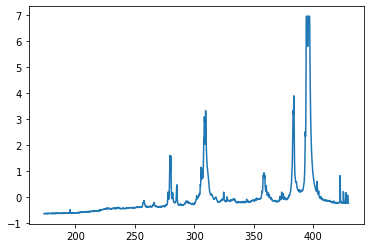

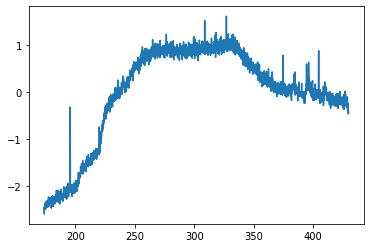

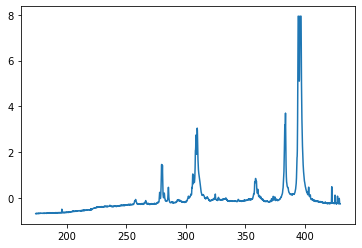

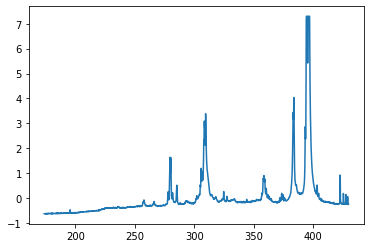

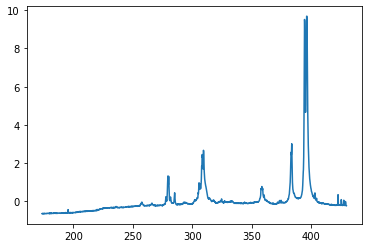

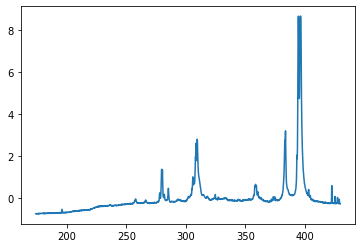

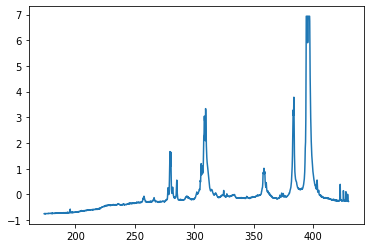

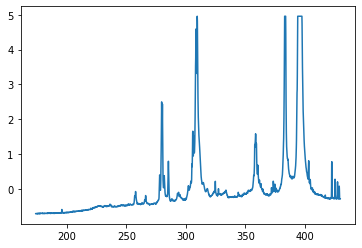

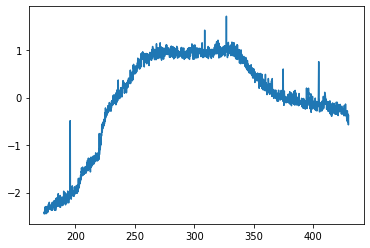

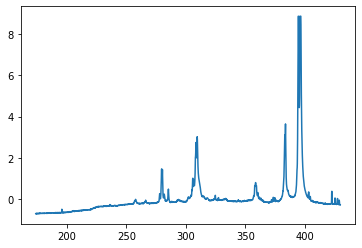

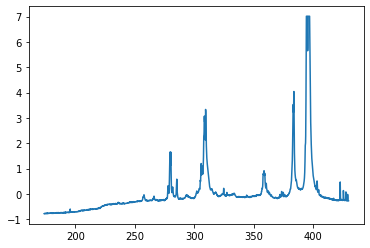

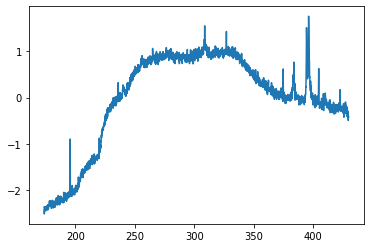

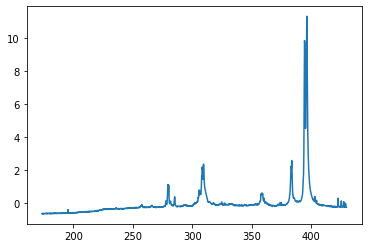

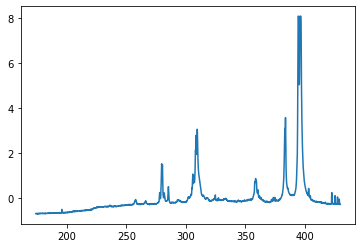

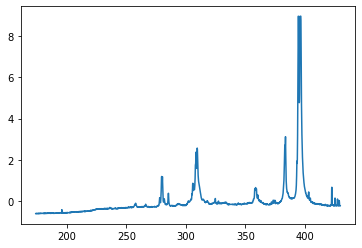

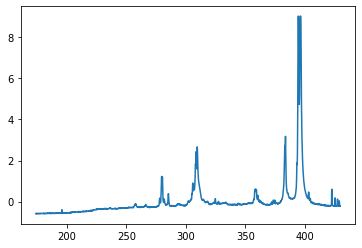

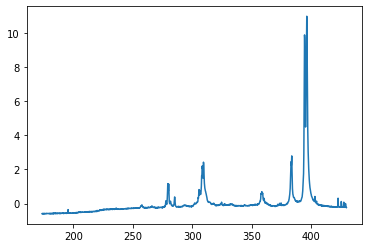

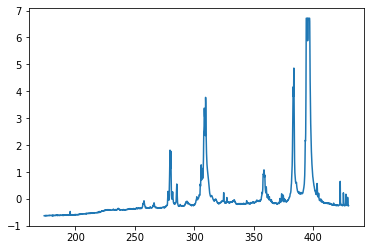

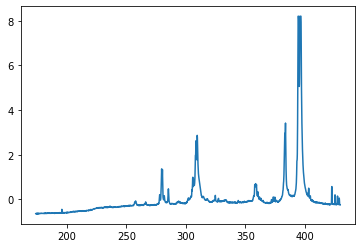

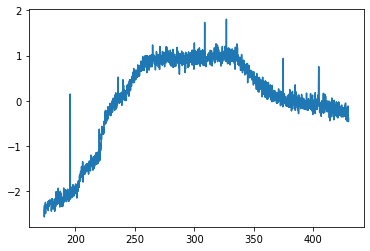

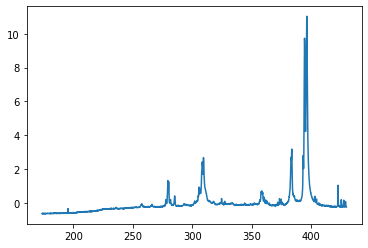

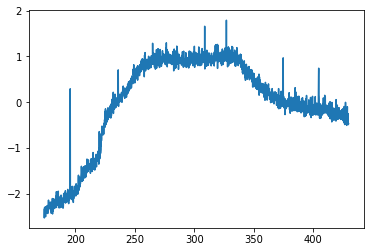

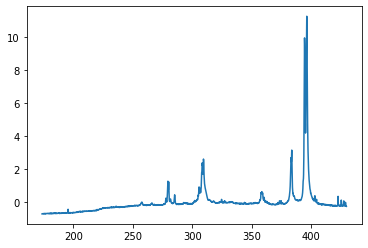

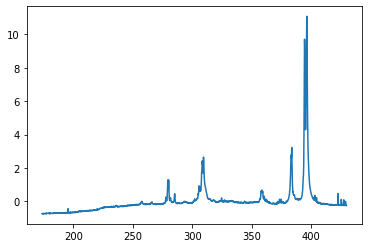

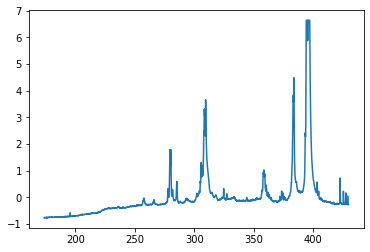

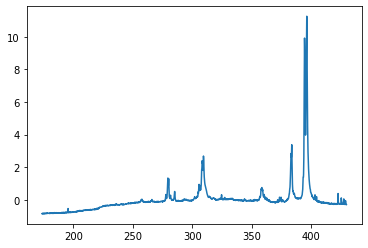

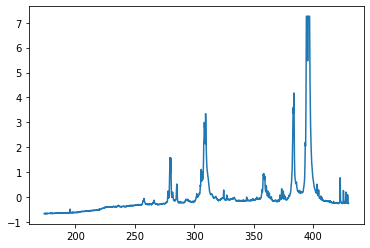

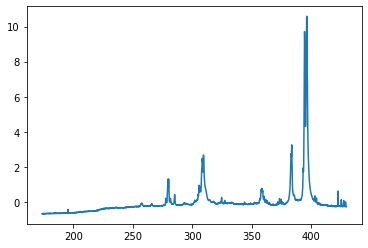

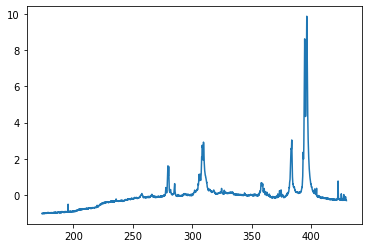

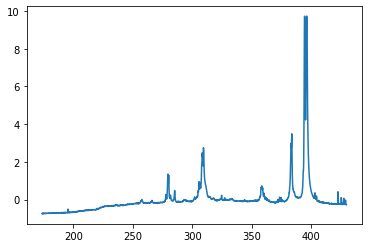

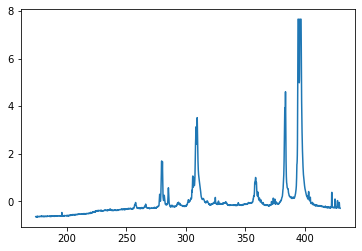

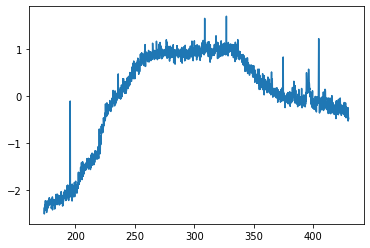

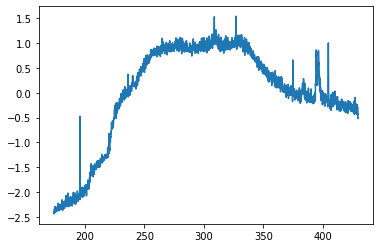

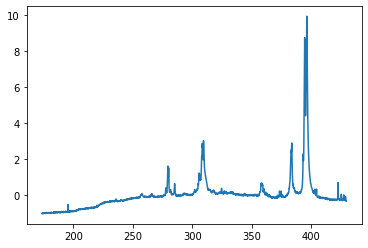

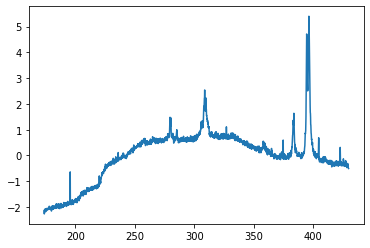

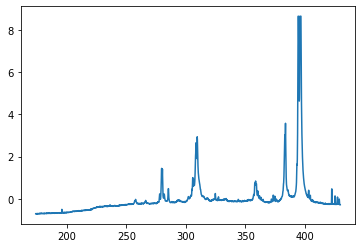

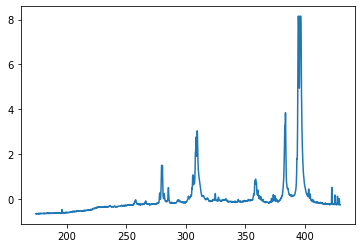

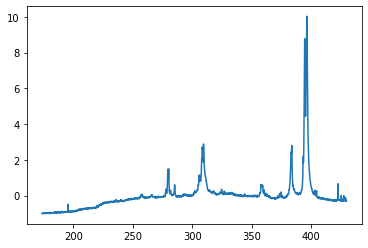

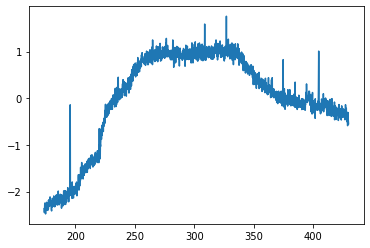

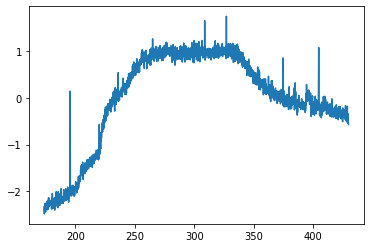

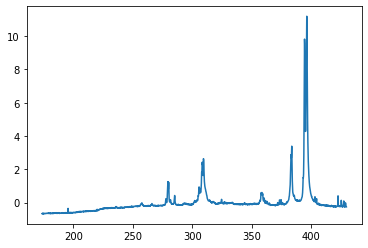

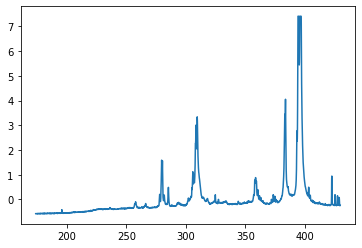

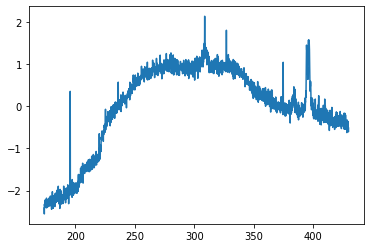

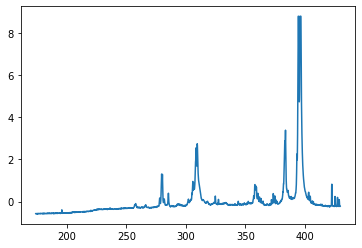

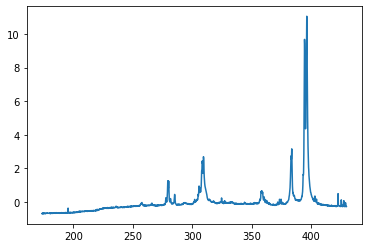

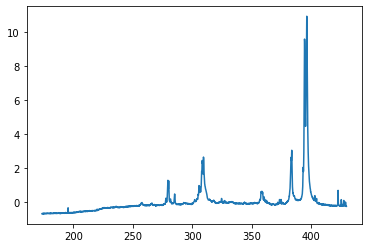

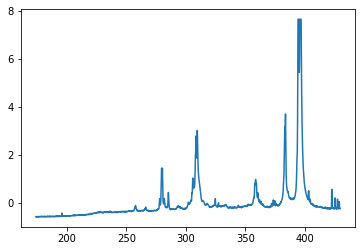

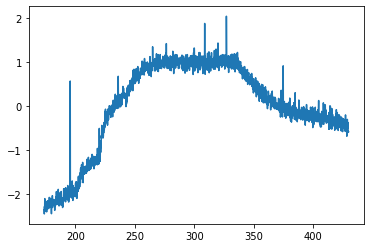

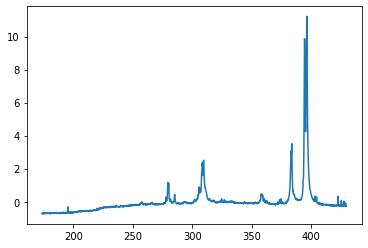

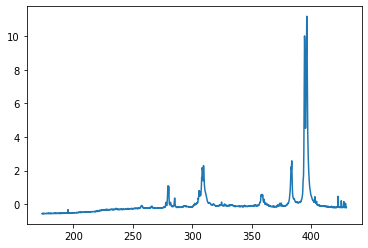

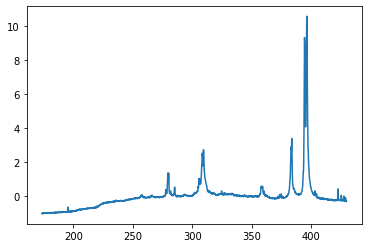

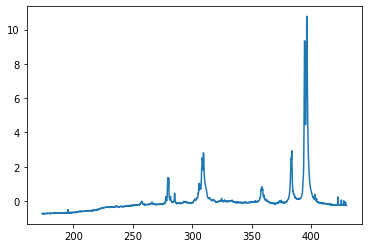

In [14]:
for i in (range(len(X_std[0]))):
    
    plt.plot(wl, X_std[:,i] )
    plt.show()
    

In [15]:
print(max(data[:,8]))
print(max(data[:,11]))
max(data[:,1])

65535
65535


4826

good spectra:  100


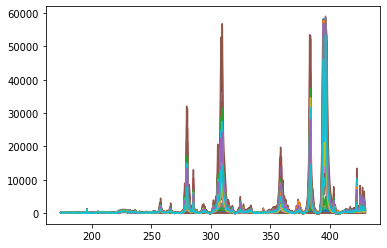

In [16]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    a = data[:,i] - z_i
    
    #a=  a / np.sum(a,axis=0)
    #a=  a / np.max(a,axis=0)


    count += 1
    #print(i)
    plt.plot(wl, a)
    #plt.show()
print("good spectra: ", count)

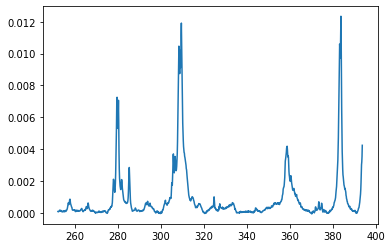

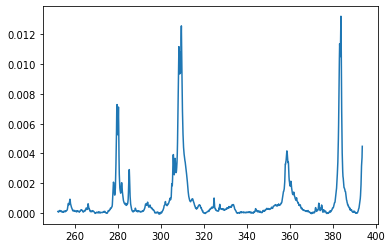

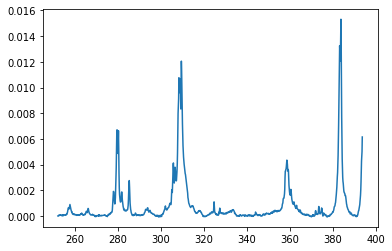

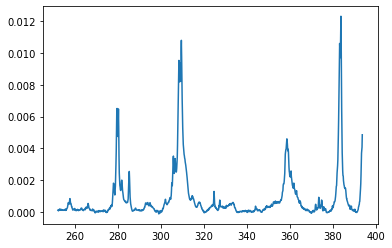

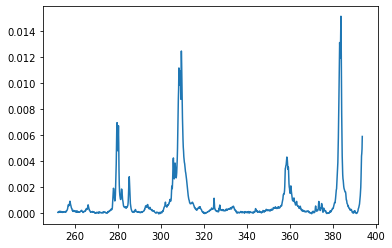

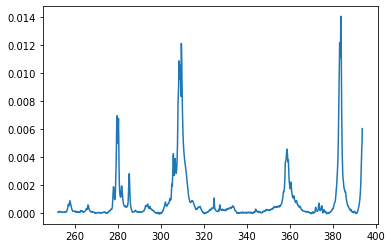

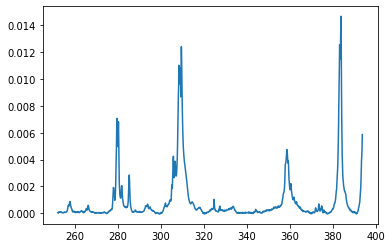

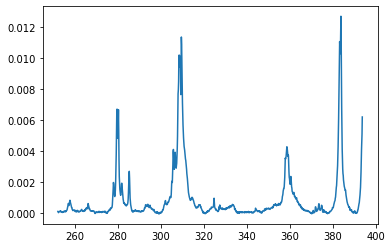

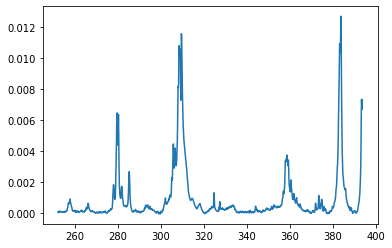

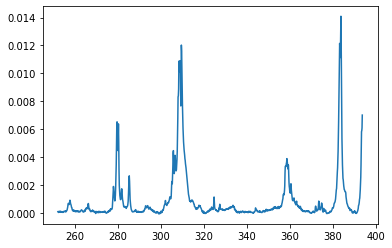

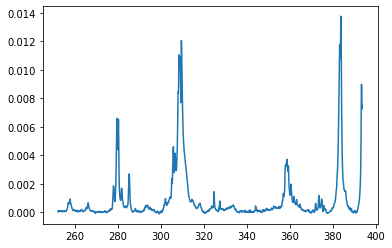

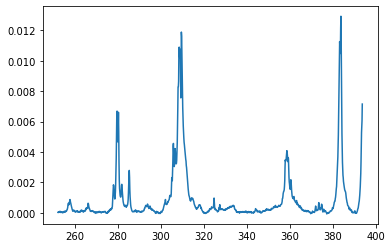

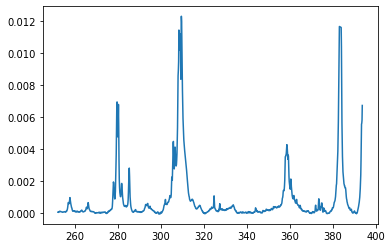

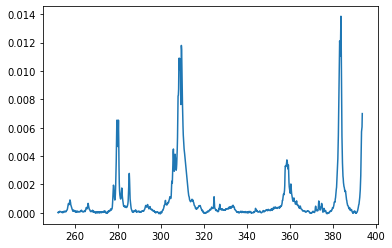

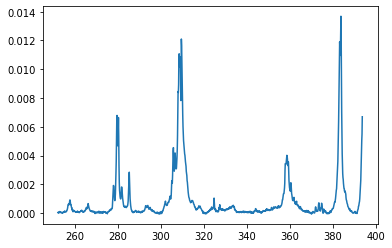

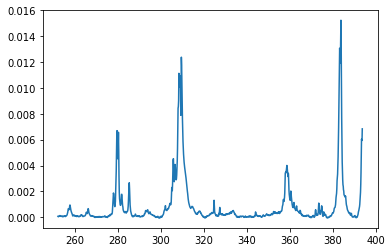

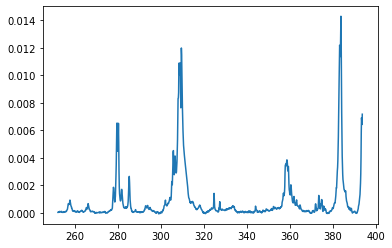

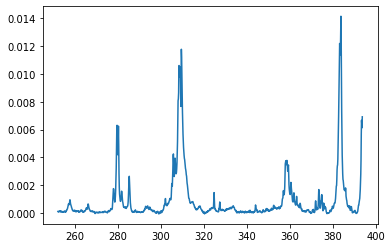

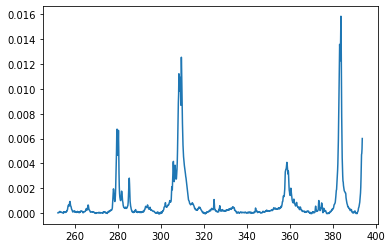

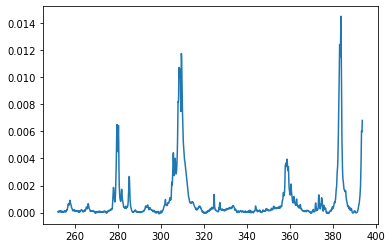

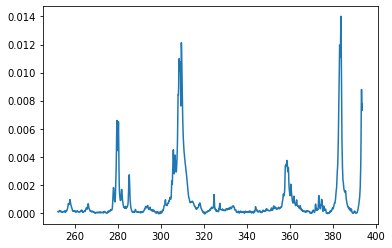

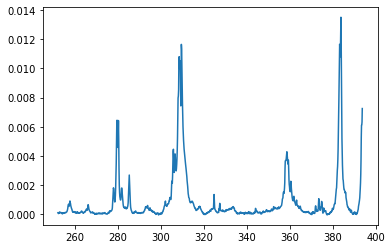

good spectra:  22


In [17]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[600:1730,i], lam, p, niter=10)
    
    a = data[600:1730,i] - z_i
    
    
    if (max(a)) > 25000:
        
        a =  a / np.sum(a,axis=0)
        #a = StandardScaler().fit_transform(a.reshape(-1, 1))
        #a= normalize(a.reshape(-1, 1))
        
        count += 1
        #print(i)
        plt.plot(wl[600:1730], a)
        plt.show()
        #plt.savefig('./graph.png')
print("good spectra: ", count)

good spectra:  29
(29, 2046)
(2046,)


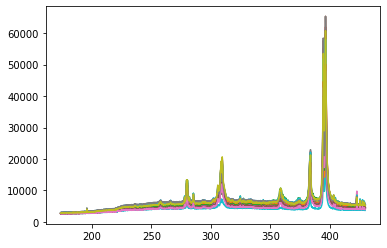

In [18]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    if ((max(data[:,i]-z_i)) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        tmp = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.max(tmp, axis=0)
#avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)




good spectra:  29
(0, 2046)
(2046,)


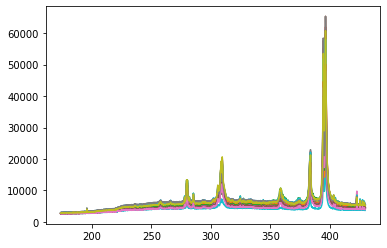

In [19]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        result_array = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)



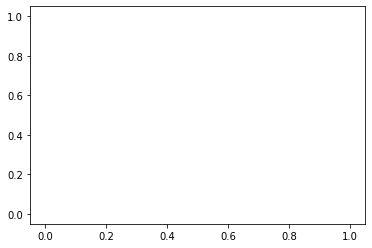

In [20]:

plt.plot(wl, avg_arr)
plt.show()

In [21]:

good = np.empty([len(wl)])

good1 = np.empty_like(wl)

print(good.shape)
print(good1.shape)

(2046,)
(2046, 1)


In [22]:
print(result_array.shape)
print(result_array)
a=np.mean(result_array, axis=0)
print(a.shape)

(1, 2046)
[[2844. 2768. 2802. ... 5224. 5235. 5238.]]
(2046,)


In [23]:
from glob import glob

#filenames = glob('./ref/*')
filenames = glob('./ref_1/*')


dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 

<class 'list'>
24


In [24]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    for i in (range(len(data[0])) ):
        
        
    
        if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [data[:,i]], axis=0)


    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

data index: 0
data 0 shape:  (2046, 100)
good spectra:  29
tmp shape:  (29, 2046)
avg array shape:  (1, 2046)

data index: 1
data 1 shape:  (2046, 69)
good spectra:  54
tmp shape:  (54, 2046)
avg array shape:  (1, 2046)

data index: 2
data 2 shape:  (2046, 35)
good spectra:  17
tmp shape:  (17, 2046)
avg array shape:  (1, 2046)

data index: 3
data 3 shape:  (2046, 40)
good spectra:  9
tmp shape:  (9, 2046)
avg array shape:  (1, 2046)

data index: 4
data 4 shape:  (2046, 35)
good spectra:  16
tmp shape:  (16, 2046)
avg array shape:  (1, 2046)

data index: 5
data 5 shape:  (2046, 32)
good spectra:  20
tmp shape:  (20, 2046)
avg array shape:  (1, 2046)

data index: 6
data 6 shape:  (2046, 32)
good spectra:  28
tmp shape:  (28, 2046)
avg array shape:  (1, 2046)

data index: 7
data 7 shape:  (2046, 34)
good spectra:  25
tmp shape:  (25, 2046)
avg array shape:  (1, 2046)

data index: 8
data 8 shape:  (2046, 33)
good spectra:  11
tmp shape:  (11, 2046)
avg array shape:  (1, 2046)

data index:

WITH BASELINE CORRECTION

data index: 0
data 0 shape:  (2046, 100)


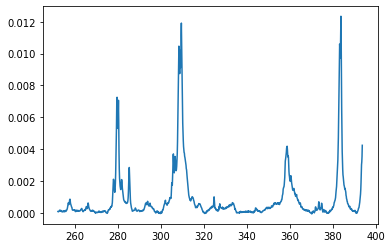

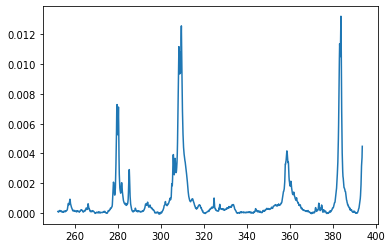

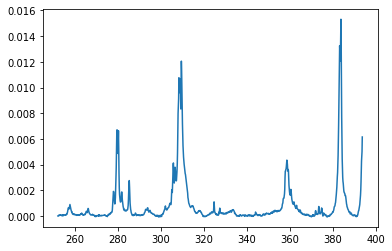

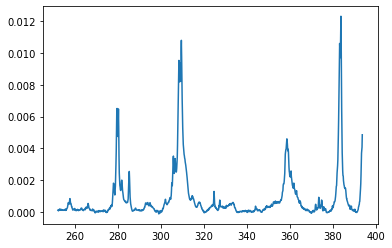

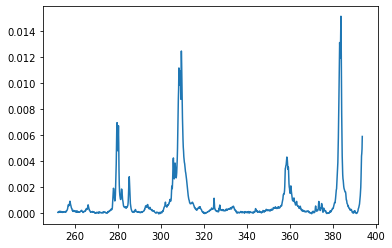

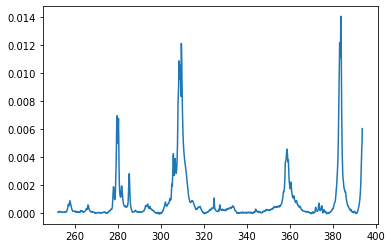

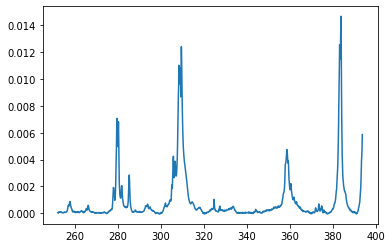

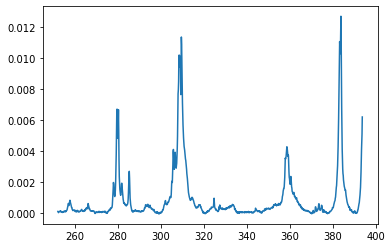

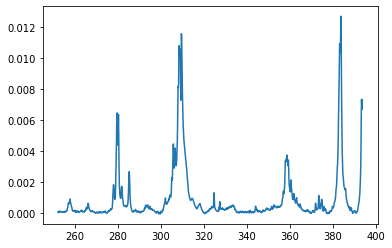

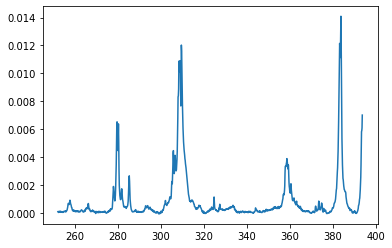

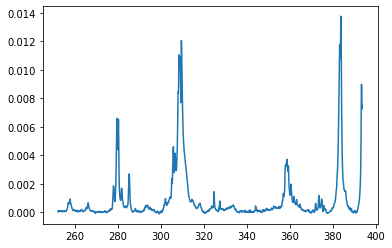

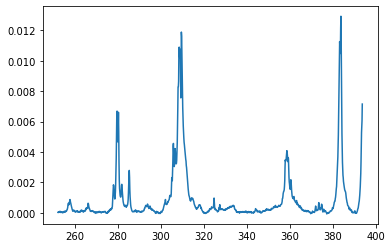

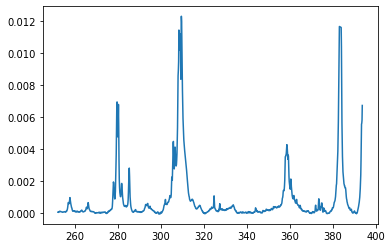

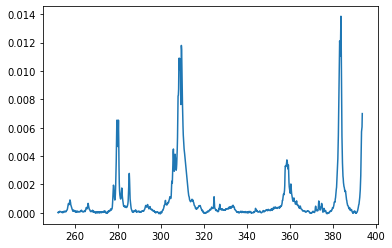

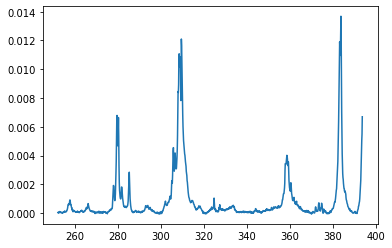

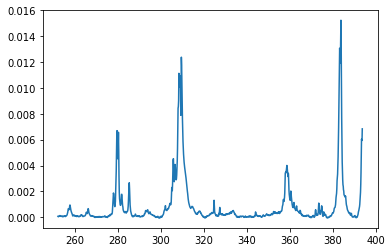

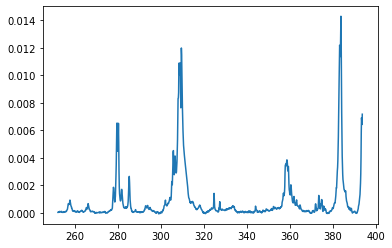

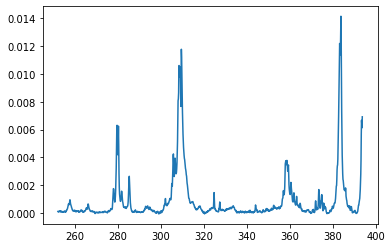

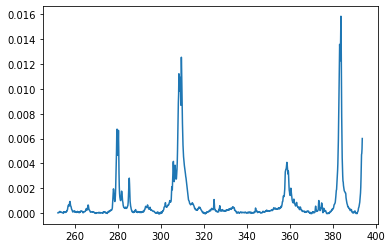

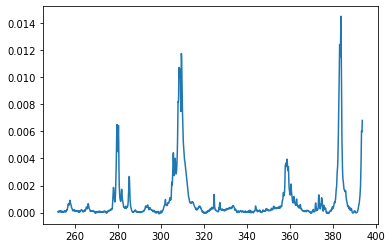

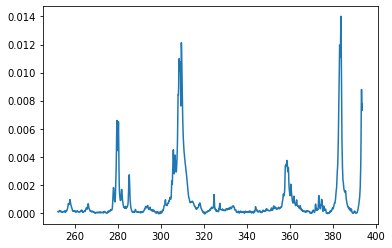

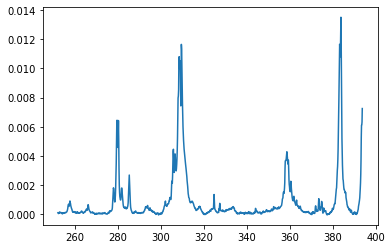

good spectra:  22
tmp shape:  (22, 1130)
avg array shape:  (1, 1130)

data index: 1
data 1 shape:  (2046, 69)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 2
data 2 shape:  (2046, 35)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 3
data 3 shape:  (2046, 40)


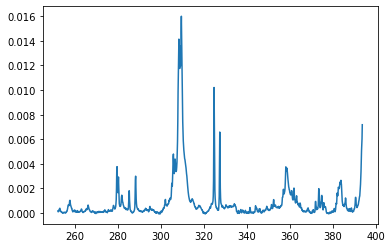

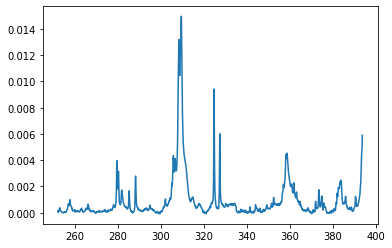

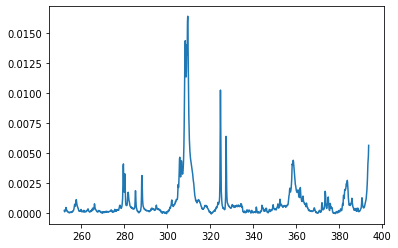

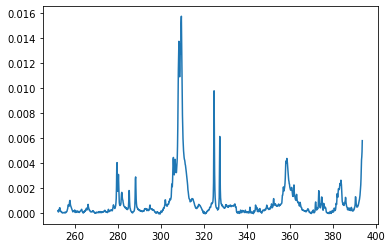

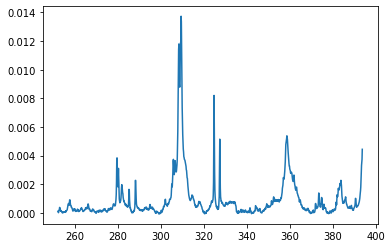

good spectra:  5
tmp shape:  (5, 1130)
avg array shape:  (1, 1130)

data index: 4
data 4 shape:  (2046, 35)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 5
data 5 shape:  (2046, 32)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 6
data 6 shape:  (2046, 32)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 7
data 7 shape:  (2046, 34)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 8
data 8 shape:  (2046, 33)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 9
data 9 shape:  (2046, 51)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 10
data 10 shape:  (2046, 35)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 11
data 11 shape:  (2046, 46)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 12
data 12 shape:  (2046, 28)
good spectra:  0
tmp s

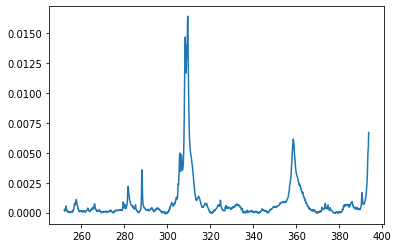

good spectra:  1
tmp shape:  (1, 1130)
avg array shape:  (1, 1130)

data index: 14
data 14 shape:  (2046, 66)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 15
data 15 shape:  (2046, 32)


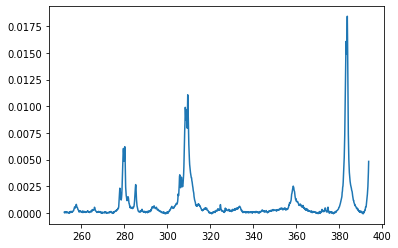

good spectra:  1
tmp shape:  (1, 1130)
avg array shape:  (1, 1130)

data index: 16
data 16 shape:  (2046, 34)


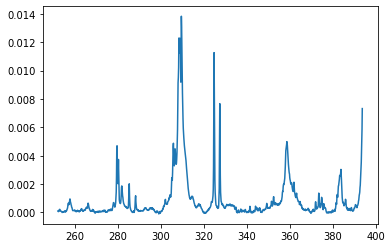

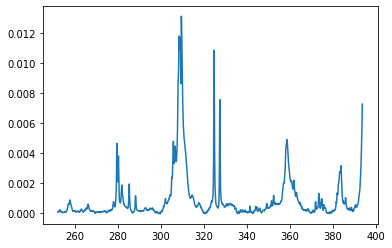

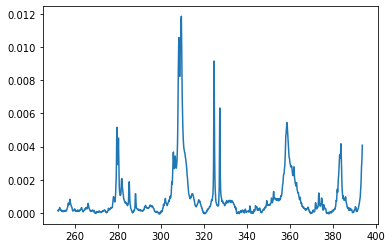

good spectra:  3
tmp shape:  (3, 1130)
avg array shape:  (1, 1130)

data index: 17
data 17 shape:  (2046, 34)


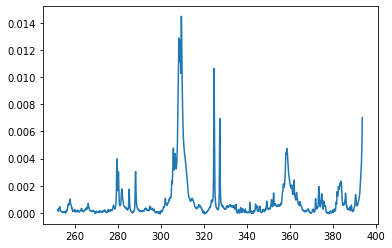

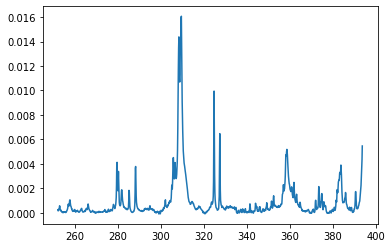

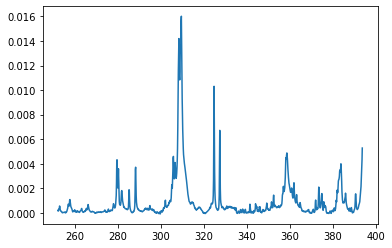

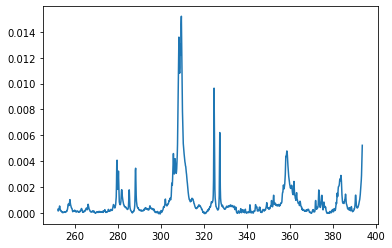

good spectra:  4
tmp shape:  (4, 1130)
avg array shape:  (1, 1130)

data index: 18
data 18 shape:  (2046, 30)


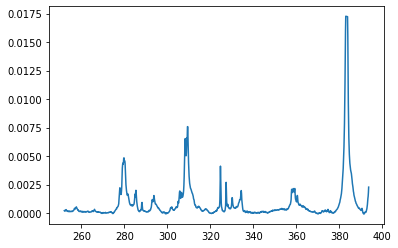

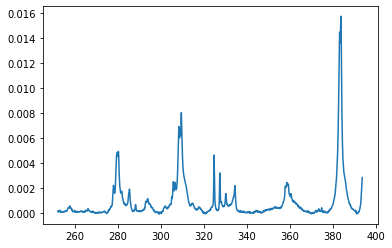

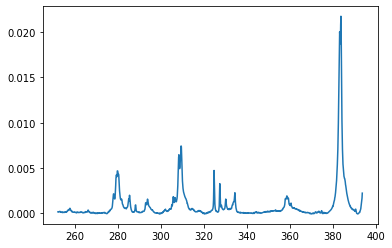

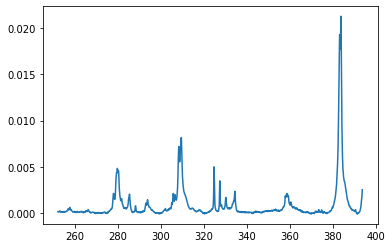

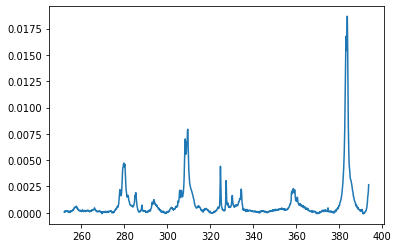

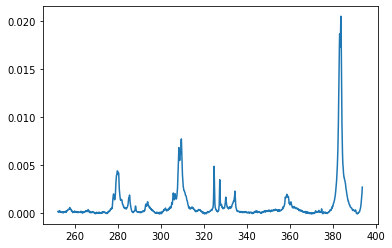

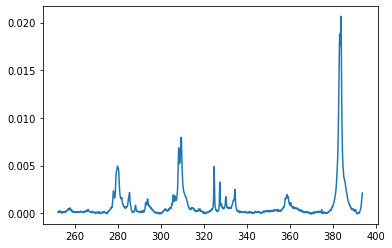

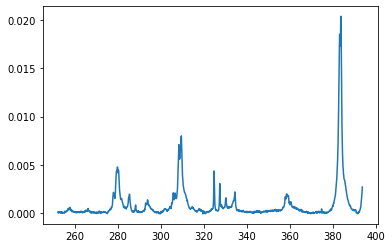

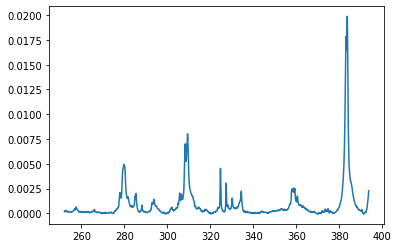

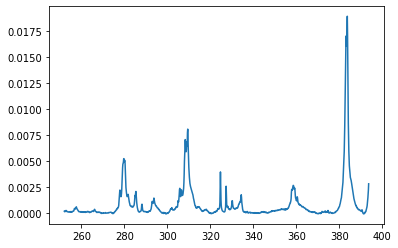

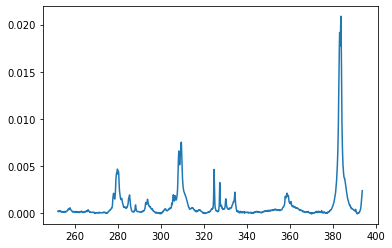

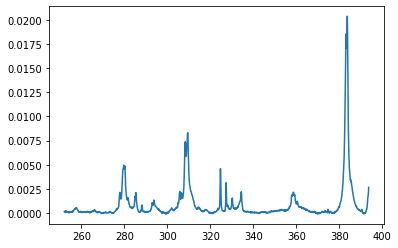

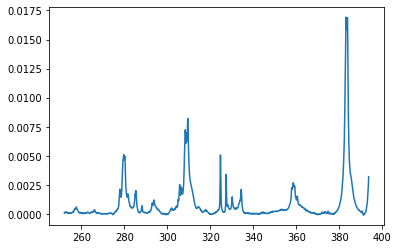

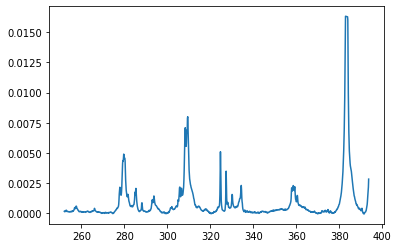

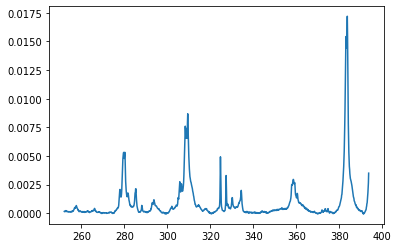

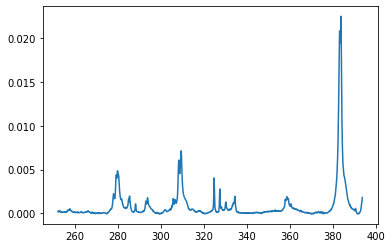

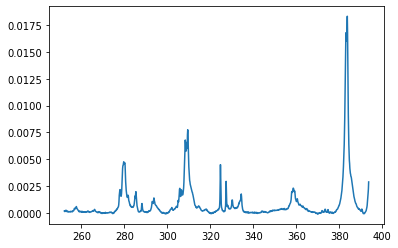

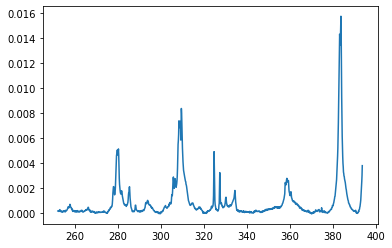

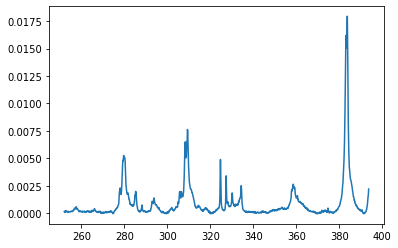

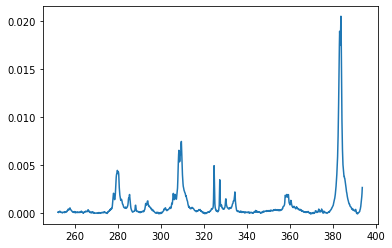

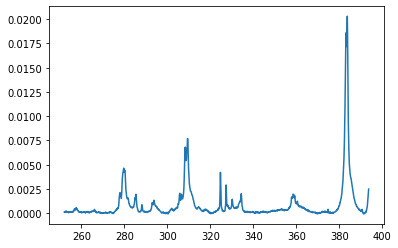

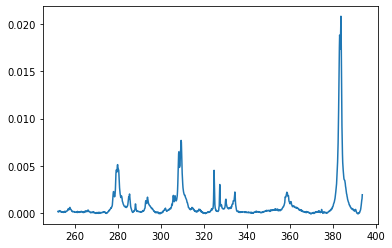

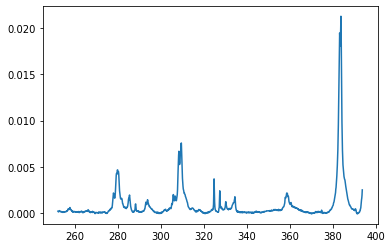

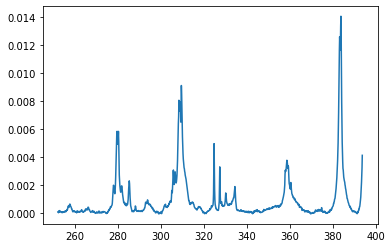

good spectra:  24
tmp shape:  (24, 1130)
avg array shape:  (1, 1130)

data index: 19
data 19 shape:  (2046, 45)


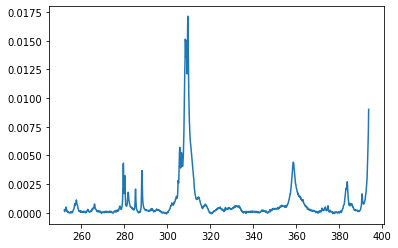

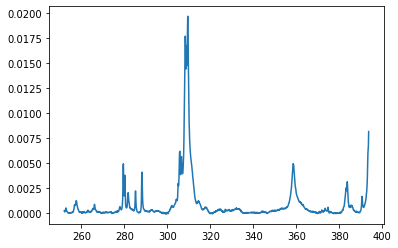

good spectra:  2
tmp shape:  (2, 1130)
avg array shape:  (1, 1130)

data index: 20
data 20 shape:  (2046, 43)


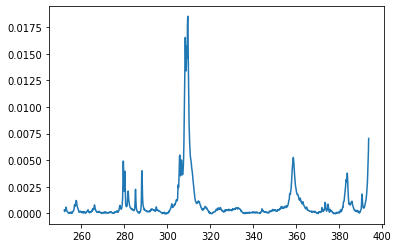

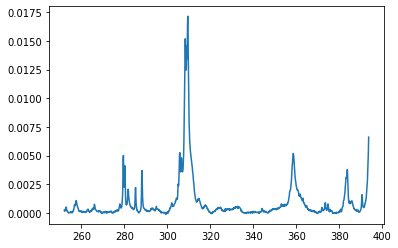

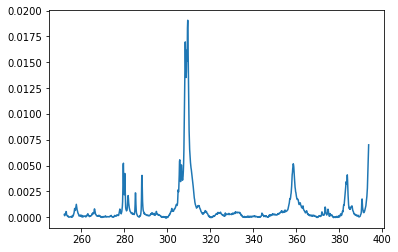

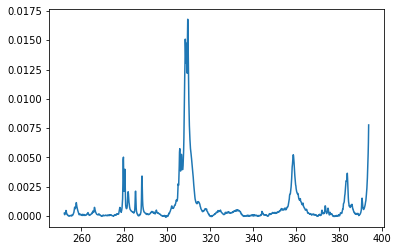

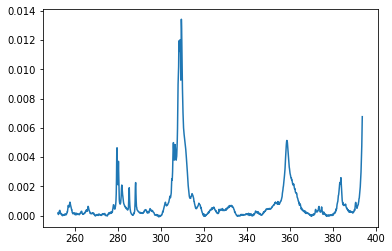

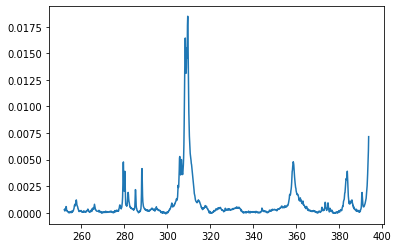

good spectra:  6
tmp shape:  (6, 1130)
avg array shape:  (1, 1130)

data index: 21
data 21 shape:  (2046, 37)


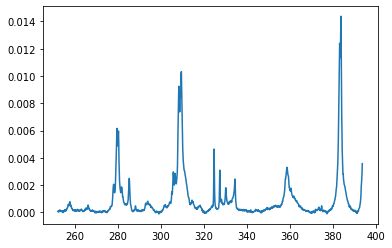

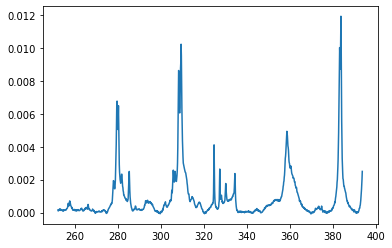

good spectra:  2
tmp shape:  (2, 1130)
avg array shape:  (1, 1130)

data index: 22
data 22 shape:  (2046, 71)
good spectra:  0
tmp shape:  (0, 1130)
avg array shape:  (1, 1130)

data index: 23
data 23 shape:  (2046, 34)


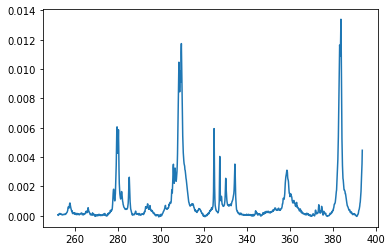

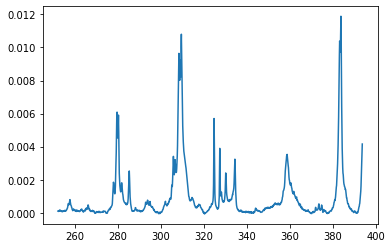

good spectra:  2
tmp shape:  (2, 1130)
avg array shape:  (1, 1130)

(24, 1130)


In [25]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
    
        z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

        a = data[600:1730,i] - z_i


        if (max(a)) > 25000:

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            plt.plot(wl[600:1730], a)
            plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [27]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
        if (max(data[:,i])) > 25000:
            
            
            z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

            a = data[600:1730,i] - z_i


        

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl[600:1730], a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

data index: 0
data 0 shape:  (2046, 100)
good spectra:  74
tmp shape:  (74, 1130)
avg array shape:  (1, 1130)

data index: 1
data 1 shape:  (2046, 69)
good spectra:  9
tmp shape:  (9, 1130)
avg array shape:  (1, 1130)

data index: 2
data 2 shape:  (2046, 35)
good spectra:  27
tmp shape:  (27, 1130)
avg array shape:  (1, 1130)

data index: 3
data 3 shape:  (2046, 40)
good spectra:  34
tmp shape:  (34, 1130)
avg array shape:  (1, 1130)

data index: 4
data 4 shape:  (2046, 35)
good spectra:  24
tmp shape:  (24, 1130)
avg array shape:  (1, 1130)

data index: 5
data 5 shape:  (2046, 32)
good spectra:  24
tmp shape:  (24, 1130)
avg array shape:  (1, 1130)

data index: 6
data 6 shape:  (2046, 32)
good spectra:  30
tmp shape:  (30, 1130)
avg array shape:  (1, 1130)

data index: 7
data 7 shape:  (2046, 34)
good spectra:  30
tmp shape:  (30, 1130)
avg array shape:  (1, 1130)

data index: 8
data 8 shape:  (2046, 33)
good spectra:  28
tmp shape:  (28, 1130)
avg array shape:  (1, 1130)

data index:

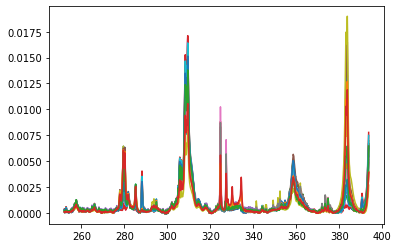

In [28]:
for i in range(len(tot)):
    plt.plot(wl[600:1730], tot[i])
    #plt.show()

In [ ]:
ded #np.savetxt("avg_intesities.csv", tot, delimiter=",", fmt='%f')

In [ ]:
print(wl.shape)
wl1= wl[600:1730].reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
a.shape
a

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')